/home/lab/anaconda3/envs/SRCNN/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/lab/anaconda3/envs/SRCNN/bin/python


/home/lab/anaconda3/envs/SRCNN/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lab/anaconda3/envs/SRCNN/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


Train - iteration : 0: 100%|██████████| 7393/7393 [4:50:25<00:00,  2.36s/it, loss_batch=0.0046, psnr=28.4841]   
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1,     2] G_loss :  0.004588
num_backprop : 7393, time :  17425.887082, test_psnr :  28.484114
[2,     2] G_loss :  nan
num_backprop : 7393, time :  0.000428, test_psnr :  28.484114
torch.Size([1, 3, 72, 72]) torch.Size([1, 3, 288, 288])
torch.Size([72, 72, 3, 1]) torch.Size([288, 288, 3, 1])


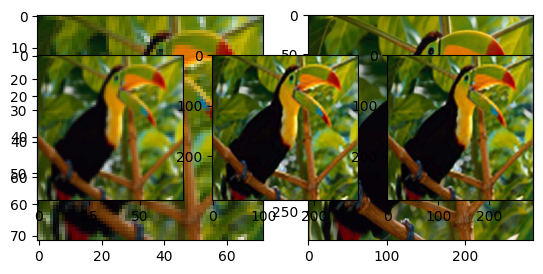

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import torch
import glob
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm #/home/lab/anaconda3/bin/python
from time import time
import dataset
import utils
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor
from torch.utils.data import Dataset, DataLoader
import models, dataset, utils
from torchvision.transforms import Compose, Resize, ToPILImage, ToTensor

# In[2]:


import sys
print(sys.executable)


# In[3]:


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# In[4]:


from torchvision.models.vgg import vgg16
vgg19_model = vgg16(pretrained=True)
features = vgg19_model.features



# In[6]:


#Custom dataloader2 (image resizing method : 4 times inter_cubic scaling for both training and test images)
def random_crop(img, x, y, patch_size):
    left = x
    upper = y
    right = x + patch_size[0]
    lower = y + patch_size[1]
    return img[upper : lower, left : right, : ]
class SRGANDataset(Dataset):
    def __init__(self, test, var = True, label = True, patch_size = (96, 96)):
        super(SRGANDataset, self).__init__()
        self.patch_size = patch_size
        self.test = test
        if test == True:
            image_var = sorted(glob.glob('/ssd1/HyunJun/dataset/Set5/LR/bicubic/X4/*.png'))
            image_label = sorted(glob.glob('/ssd1/HyunJun/dataset/Set5/HR/*.png'))
        else:
            image_var = sorted(glob.glob('/ssd1/HyunJun/dataset/DIV2K_train/DIV2K_train_LR_bicubic/X4/*.png'))
            image_label = sorted(glob.glob('/ssd1/HyunJun/dataset/DIV2K_train/DIV2K_train_HR/*.png'))
        var = []
        label = []
        for img_path_var, img_path_label in zip(image_var, image_label):
            torch.cuda.empty_cache() 
            img_var = cv2.imread(img_path_var)
            img_label = cv2.imread(img_path_label)
            img_var = cv2.cvtColor(img_var, cv2.COLOR_BGR2RGB)
            img_label = cv2.cvtColor(img_label, cv2.COLOR_BGR2RGB)
            img_var = cv2.resize(img_var, dsize = (0, 0), fx = 4, fy = 4, interpolation = cv2.INTER_CUBIC)
            if test == True:
                #label.append(img_label/127.5 - 1)
                label.append(img_label/255)
                img_var = cv2.resize(img_var, dsize = (0, 0), fx = 1/4, fy = 1/4, interpolation= cv2.INTER_AREA)
                var.append(img_var/255) 
            else:
                img_height, img_width, _ = img_var.shape
                for _ in range(16):
                    x = np.random.randint(1, img_width - patch_size[0])
                    y = np.random.randint(1, img_height - patch_size[1])
                    
                    #create label
                    cropped_label_img = random_crop(img_label, x, y, patch_size)
                    #label.append(cropped_label_img/127.5 - 1)
                    label.append(cropped_label_img/255)

                    #create var
                    cropped_var_img = random_crop(img_var, x, y, patch_size)
                    cropped_var_img = cv2.resize(cropped_var_img, dsize = (0, 0), fx = 1/4, fy = 1/4, interpolation= cv2.INTER_AREA)
                    var.append(cropped_var_img/255)
        self.var = var 
        self.label = label
    def __getitem__(self, index):
        var = self.var[index]
        label = self.label[index]
        return var, label
    def __len__(self):
        return len(self.var)
#dataset_train = SRGANDataset(test = False)
#dataloader_train = DataLoader(dataset = dataset_train, batch_size = 16, shuffle = True)
dataDir='..'
dataType='val2017'
dataset_train = dataset.train_dataset_version2(utils.root, utils.training_dataset_json.format(dataDir,dataType))
dataloader_train = DataLoader(dataset= dataset_train, batch_size=16, shuffle=True, collate_fn= dataset.collate_fn_version2, num_workers=10)
dataset_test = SRGANDataset(test = True)
dataloader_test = DataLoader(dataset = dataset_test, batch_size = 16, shuffle = True)


# In[7]:


img1, img2 = dataset_test[1]
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(img2)


# In[8]:


class SRresnet(nn.Module):
    def __init__(self):
        super(SRresnet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size= 9, stride= 1, padding= 4), 
            nn.PReLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block6 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64),
            nn.PReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block7 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size= 3, stride= 1, padding= 1),
            nn.BatchNorm2d(64)
        )
        self.block8 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels = 256, kernel_size= 3, stride= 1, padding= 1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.block9 = nn.Sequential(
            nn.Conv2d(in_channels= 64, out_channels = 256, kernel_size= 3, stride= 1, padding= 1),
            nn.PixelShuffle(2),
            nn.PReLU()
        )
        self.block10 = nn.Conv2d(in_channels = 64, out_channels= 3, kernel_size = 9, stride = 1, padding= 4)
        
      
    def forward(self, x):
        y = self.block1(x)
        #print(y[0][0][0][0])
        x = torch.add(y, self.block2(y))
        #print(x[0][0][0][0])
        x = torch.add(x, self.block3(x))
        #print(x[0][0][0][0])
        x = torch.add(x, self.block4(x))
        #print(x[0][0][0][0])
        x = torch.add(x, self.block5(x))
        #print(x[0][0][0][0])
        x = torch.add(x, self.block6(x))
        #print(x[0][0][0][0])
        x = torch.add(y, self.block7(x))
        #print(x[0][0][0][0])
        x = self.block8(x)
        #print(x[0][0][0][0])
        x = self.block9(x)
        #print(x[0][0][0][0])
        x = self.block10(x)
        #print(x[0][0][0][0])
        return x


# In[15]:


#Define loss_function
class VGG_loss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg_network = nn.Sequential(*list(vgg19_model.features[:31])).eval().to('cuda')
        for param in vgg_network.parameters():
            param.requires_grad = False
        self.vgg = vgg_network
        self.criterion = nn.MSELoss()
    def forward(self, generated_images, target_images):
        # = (generated_features + 1)/2
        #target_features = (target_features + 1)/2
        loss = self.criterion(self.vgg(generated_images), self.vgg(target_images)) * 0.0006
        return loss
class adversial_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.BCEWithLogitsLoss()
    def forward(self, discrimination):
        #print(discrimination) #-> approaching zero
        targets = torch.ones_like(discrimination)
        loss = self.criterion(targets, discrimination)
        return loss
class Generator_loss(nn.Module):
    def __init__(self, alpha = 0.001, rescaling_factor = 0.006):
        super().__init__()
        self.rescaling_factor = rescaling_factor
        self.alpha = alpha
        self.VGG_loss = VGG_loss()
        self.MSE_loss = nn.MSELoss()
        self.adversial_loss = adversial_loss()
    def forward(self, fake_img, labels):
        return self.MSE_loss(fake_img, labels) #+ self.VGG_loss(fake_img, labels)
class Discriminator_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.BCEWithLogitsLoss()
    def forward(self, discriminated_real_images, discriminated_fake_images):
        fake_label = torch.zeros_like(discriminated_fake_images)
        real_label = torch.ones_like(discriminated_real_images)
        fake_loss = self.loss(discriminated_fake_images, fake_label)
        real_loss = self.loss(discriminated_real_images, real_label)
        return (fake_loss + real_loss)/2


# In[11]:


def psnr(psnr_real_targets, psnr_generated_targets):
    mse_max = 1
    mse = (psnr_real_targets - psnr_generated_targets) ** 2
    mse = mse.detach().cpu().numpy()
    mse_value = np.sqrt(mse.mean())
    psnr_picture = 20 * np.log10(mse_max / mse_value)
    return psnr_picture 

def test(G):
    if G is not None:
        G.eval()
    with torch.no_grad():
        inputs, targets = dataset_test[1]
        #targets = 0.5 * (targets + 1)
        
        #Apply the formation transforms
        inputs = torch.tensor(inputs).to('cuda').float().unsqueeze(0)
        targets = torch.tensor(targets).to('cuda').float().unsqueeze(0)
        #print(inputs.shape, targets.shape)    
        #print(inputs[0][0][0][0], targets[0][0][0][0])
        #Change the input into the desired form
        targets = targets.permute(0, 3, 1, 2)
        inputs = inputs.permute(0, 3, 1, 2)
        outputs = G(inputs)
        #print(outputs[0][0][0][0])
        
        #Model output
        return targets, inputs, outputs
    
def train(epochs):
    G = SRresnet()
    G.to('cuda')
    Loss_fn_G = nn.MSELoss()
    G.train()
    #Optimizer
    #lambda1 = lambda epoch: 0.999995 ** epoch
    optimizerG = torch.optim.Adam(G.parameters(), lr = 0.0001, betas = (0.9, 0.999))
    #lr_schedulerr = torch.optim.lr_scheduler.LambdaLR(optimizer   = optimizerG,
                                            #lr_lambda= lambda1
                                            #)
    number_of_backpropagation = 0
    loop_train = tqdm(
                enumerate(dataloader_train, 1),
                total=len(dataloader_train),
                desc="Train",
                position=0,
                leave=True,
            )
    for epoch in range(epochs):
        start_time = time()    
        G_train_loss = []
        for idx , data in loop_train:
            labels, inputs, _ = data[0].to('cuda'), data[1].to('cuda'), data[2].to('cuda')
            #inputs = inputs.permute(0, 2, 3, 1).to(torch.float32)
            #labels = labels.permute(0, 2, 3, 1).to(torch.float32)

            #Generator : Optimization
            optimizerG.zero_grad()
            gen = G(inputs)
            loss = Loss_fn_G(gen, labels)
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(G.parameters(), max_norm=1.0)
            optimizerG.step()
            #lr_schedulerr.step()
            G_train_loss.append(loss.item())
            #print(inputs[0][0][0][0])
            number_of_backpropagation = number_of_backpropagation + 1 
            targets, _, generated_images = test(G)
            test_psnr = psnr(targets, generated_images)
            loop_train.set_description(f"Train - iteration : {epoch}")
            loop_train.set_postfix(
                loss_batch="{:.4f}".format(torch.tensor(G_train_loss).mean()),
                psnr="{:.4f}".format(test_psnr),
                refresh=True,
                
            )    
        print(f'[{epoch + 1}, {epochs:5d}] G_loss : {torch.tensor(G_train_loss).mean() : 3f}')
        print(f'num_backprop : {number_of_backpropagation}, time : {time() - start_time : 3f}, test_psnr : {test_psnr : 5f}')
    return G
        


# In[16]:


epochs = 2
G = train(epochs)
targets, inputs, generated_images = test(G)
print(inputs.shape, targets.shape)
inputs = inputs.permute(2, 3, 1, 0)
targets = targets.permute(2, 3, 1, 0)
generated_images = generated_images.permute(2, 3, 1, 0)
print(inputs.shape, targets.shape)
#image coordination
inputs_height, inputs_width, _ , _ = inputs.shape
gen_size_height, gen_size_width, _ , _ = generated_images.shape
target_size_height, target_size_width, _ , _ = targets.shape
inputs = inputs.view(inputs_height, inputs_width, 3)
generated_images = generated_images.view(gen_size_height, gen_size_width, 3)
targets = targets.view(target_size_height, target_size_width, 3)
generated_images, targets, inputs = generated_images.detach().cpu().numpy(), targets.detach().cpu().numpy(), inputs.detach().cpu().numpy()

#plot
plt.subplot(1, 3, 1)
plt.imshow(inputs)
plt.subplot(1, 3, 2)
plt.imshow(generated_images)
plt.subplot(1, 3, 3)
plt.imshow(targets)


# In[ ]:


targets, inputs, generated_images = test(G)
generated_images = generated_images.permute(2, 3, 1, 0)
gen_size_height, gen_size_width, _ , _ = generated_images.shape
generated_images = generated_images.view(gen_size_height, gen_size_width, 3)
generated_images = generated_images.detach().cpu().numpy()
plt.imshow(generated_images)

# In[18]:


cv2.imwrite("generated_image.jpg", generated_images*255)
PATH = '/ssd1/HyunJun/SRGAN/model/'
torch.save(G.state_dict(), PATH + 'model3.pt')



TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

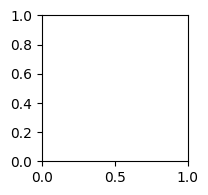

In [2]:
plt.subplot(1, 3, 1)
plt.imshow(inputs)
plt.subplot(1, 3, 2)
plt.imshow(generated_images)
plt.subplot(1, 3, 3)
plt.imshow(targets)